In [3]:
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import scipy.stats as stats

def boltzmann_exploration(q_values, temperature):
    max_q = np.max(q_values)
    exp_q = np.exp((q_values - max_q) / temperature)
    probabilities = exp_q / np.sum(exp_q)
    return probabilities

def train(episodes=4000, learning_rate=0.1, discount_factor=0.9, cost_of_living=0.01, T=100, render=False, isSlippery=True, label='base', exploration_strategy='epsilon_greedy', temperature=1.0):
    pygame.init()

    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery=isSlippery, render_mode='human' if render else None)
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    random_number_generator = np.random.default_rng()
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    steps_per_episode = []

    for i in range(episodes):
        state = env.reset()[0]
        steps = 0

        for step in range(T):
            if exploration_strategy == 'epsilon_greedy':
                if random_number_generator.random() < 0.1:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(q_table[state, :])
            elif exploration_strategy == 'boltzmann':
                probabilities = boltzmann_exploration(q_table[state, :], temperature)
                action = random_number_generator.choice(np.arange(len(probabilities)), p=probabilities)

            new_state, reward, terminated, truncated, _ = env.step(action)

            if terminated & (reward == 0):
                reward = reward - 1

            if reward == 1:
                rewards_per_episode[i] = 1
                time_rewards_per_episode[i] = 1 - steps * cost_of_living
                steps_per_episode.append(steps)
                reward = reward - cost_of_living * steps

            q_table[state, action] += reward + learning_rate * (reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action])

            state = new_state
            steps += 1

            if terminated or truncated:
                break

        if exploration_strategy == 'epsilon_greedy':
            epsilon = max(epsilon - epsilon_decay, 0)
            if epsilon == 0:
                learning_rate = learning_rate * 0.1

    env.close()
    pygame.quit()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes) :
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)


    moving_average_window = 3000
    moving_averages = savgol_filter(rewards_per_episode * 100 , moving_average_window, 5)

    plt.plot(moving_averages, label=f'{label}')

    plt.ylim(0, 100)

    plt.title(label)

    plt.legend()

    print("__________________________________")

    print(f"{label}")

    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode) * 0.9):])
    print(f"Mean reward rate: {mean_reward_rate}")

    mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode) * 0.9):])
    print(f"Mean steps per success episode: {mean_steps}")


def run(episodes=1):
    global q_table
    pygame.init()
    env = gym.make("FrozenLake8x8-v1", is_slippery=True, render_mode='human')
    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = np.argmax(q_table[state, :])
            new_state, reward, terminated, truncated, _ = env.step(action)
            state = new_state
    env.close()
    pygame.quit()

__________________________________
Boltzmann T=0.1
Mean reward rate: 0.2275
Mean steps per success episode: 67.82456140350877
__________________________________
Boltzmann T=0.01
Mean reward rate: 0.3
Mean steps per success episode: 65.38372093023256
__________________________________
Boltzmann T=0.001
Mean reward rate: 0.435
Mean steps per success episode: 59.6474358974359
__________________________________
Boltzmann T=0.0001
Mean reward rate: 0.255
Mean steps per success episode: 68.60747663551402


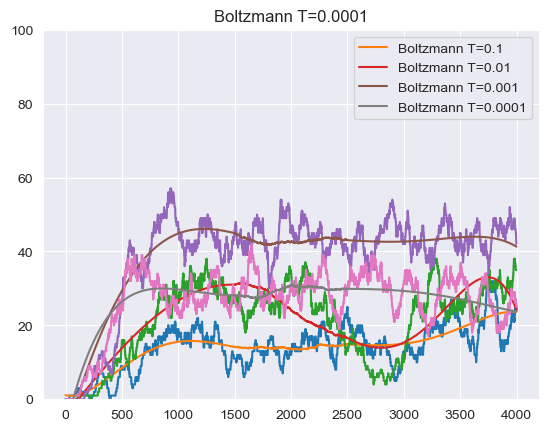

In [46]:
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.1, label='Boltzmann T=0.1')
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.01, label='Boltzmann T=0.01')
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.001, label='Boltzmann T=0.001')
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.0001, label='Boltzmann T=0.0001')

### Hyperparams

On this plot 4 different options of temperature is shown, here it might be seen Boltzmann T=0.001 has the highest Mean reward rate which corresponds to better policy. 
Also the lower temperature gets, the faster it gets to optimal policy and here are no improvement after that.

#### Mechanism

Boltzmann exploration uses a probabilistic approach to balance exploration and exploitation. The mechanism involves selecting actions based on a probability distribution (softmax) derived from the Q-values and a temperature parameter

Q-Values are used to determine the probability of selecting each action by taking its expected return.

Temperature Parameter: The temperature parameter $T$ controls the exploration-exploitation trade-off. High temperatures result in more exploration, where the agent is more likely to choose suboptimal actions. Low temperatures result in more exploitation, where the agent is more likely to choose the optimal actions. The temperature effectively scales the differences between Q-values(softmax use exponential so when we scale initial Q-values after softmax the difference in probabilities will be bigger then difference between initial values).

The Boltzmann exploration function computes the probabilities of selecting each action based on the Q-values and the temperature parameter. The softmax function is used to convert the Q-values into probabilities.

The agent selects an action based on the computed probabilities. This introduces randomness into the action selection process, but still follow some probabilisticly more logical action, ut not completely random.



### Temperature Effect on Learning and Exploration

##### High Temperature ($T$ is large):

The Q-values become smaller with same proportions, resulting in a more uniform probability distribution.

The agent is more likely to explore, as the differences between Q-values are less pronounced.

##### Low Temperature ($T$ is small):

The  Q-values become larger with same proportions, resulting in a probability distribution that favors the actions with higher Q-values.

The agent is more likely to exploit, selecting actions that are believed to be optimal.

##### Extremely Low Temperature (T approaches zero):

The action with the highest Q-value dominates the probability distribution $(p_{max_q} \rightarrow 1, T \rightarrow \inf)$, leading to greedy action selection.

##### Extremely High Temperature (T approaches infinity):

$$
Q'_{i,j} = \frac{Q_{i,j}}{T}
$$

When $T \rightarrow \inf$ then all $Q' \rightarrow 0$ which lead to all actions have nearly equal probabilities, leading to random action selection.

__________________________________
Epsilon-Greedy
Mean reward rate: 0.0225
Mean steps per success episode: 63.0
__________________________________
Boltzmann T=0.01
Mean reward rate: 0.3225
Mean steps per success episode: 66.10526315789474
__________________________________
Boltzmann T=0.001
Mean reward rate: 0.4425
Mean steps per success episode: 65.71739130434783


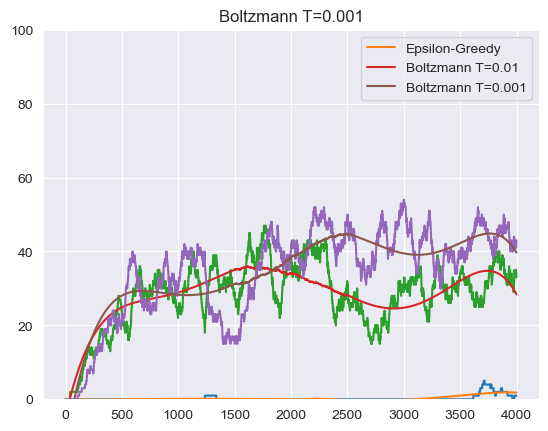

In [51]:
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='epsilon_greedy', label='Epsilon-Greedy')
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.01, label='Boltzmann T=0.01')
train(episodes=4000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.001, label='Boltzmann T=0.001')

__________________________________
Boltzmann T=0.001
Mean reward rate: 0.476
Mean steps per success episode: 63.62020905923345
__________________________________
Epsilon
Mean reward rate: 0.3815
Mean steps per success episode: 62.32218309859155


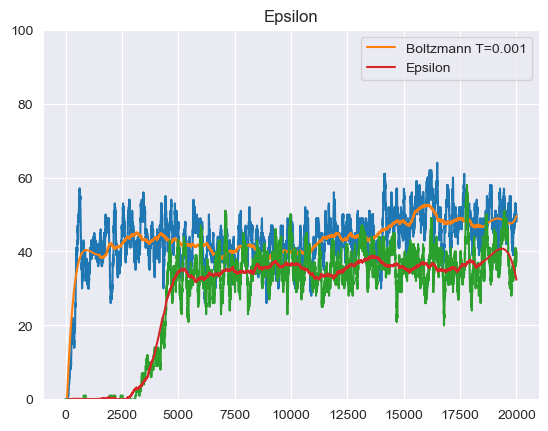

In [52]:
train(episodes=20000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='boltzmann', temperature=0.001, label='Boltzmann T=0.001')
train(episodes=20000, learning_rate=0.05, cost_of_living=0.005, render=False, exploration_strategy='epsilon_greedy', label='Epsilon')

Boltzmann exploration strategy indicates slight better result then Epsilon-Greedy(no epsilon-decay). The key difference is that Boltzmann converges to optimal policy faster then Epsilon-Greedy and then gradually increase it.

Also it is possible to have adaptive exploration-exploitation trade-off by changing the temperature parameter dynamically, There exist paper called 'An Alternative Softmax Operator for Reinforcement Learning' by Kavosh Asadi andMichael L. which reviews special cases of Boltzmann exploration strategy called Mellowmax.

## Task 2

### Random agent and rare events

The setupo involves running the agent for a specified number of episodes (`episodes=10000`), where in each episode, the agent takes random actions until it either terminates or reaches the maximum number of steps (`T=100`) no learning so trajectories are independent. The code initializes the environment with `is_slippery` set to `False` and without rendering. This setup ensures that the agent's movements are deterministic and do not involve slippery transitions.

When the agent successfully reaches the goal (`reward = 1`), the number of episodes since the last success is saved. This count is stored in the `episode_lengths` list. The variable `prev` keeps track of the episode number of the last success, allowing the calculation of the number of episodes between successive successful attempts.

The mean number of episodes between two successful attempts is calculated using the formula:
$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
where $x_i$ represents the episode lengths between successes, and $n$ is the total number of successful episodes.

To assess the reliability of this mean estimate, a 95% confidence interval is calculated using the t-distribution. The standard deviation $ s$ of the episode lengths is computed as:
$$
s = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2}
$$
The standard error of the mean (SE) is then given by:
The margin of error (ME) is calculated using the critical value from the t-distribution $t_{\frac{\alpha}{2}, n-1} $, where $\alpha = 0.05$ for a $95%$ confidence level:
$$
\text{ME} = t_{\frac{\alpha}{2}, n-1} \times \frac{s}{\sqrt{n}}
$$
Finally, the confidence interval (CI) is determined by:
$$
\text{CI} = (\bar{x} - \text{ME}, \bar{x} + \text{ME})
$$

The output of the code provides both the average number of episodes between two successful attempts and the 95% confidence interval for this estimate, offering a comprehensive understanding of the agent's performance in this specific setup. This detailed approach helps rigorously investigate the claim about the agent's learning performance when the frequent reward is turned off.

In [18]:

def random_agent(episodes=1000, T=100, isSlippery=False):
    env = gym.make("FrozenLake8x8-v1", is_slippery=isSlippery, render_mode=None)
    episode_lengths = []
    prev = 0
    for episode in range(episodes):
        state = env.reset()[0]
        for step in range(T):
            action = env.action_space.sample()
            new_state, reward, terminated, truncated, _ = env.step(action)
            if terminated:
                if reward == 1:
                    episode_lengths.append(episode - prev)
                    prev = episode
                break
    env.close()
    return episode_lengths

episode_lengths = random_agent(episodes=10000, T=100, isSlippery=False)
mean_length = np.mean(episode_lengths)
confidence_interval = stats.t.interval(0.95, len(episode_lengths)-1, loc=mean_length, scale=stats.sem(episode_lengths))

print(f"Average number of episodes between two success: {mean_length}")
print(f"95% confidence interval: {confidence_interval}")


Average number of episodes between two success: 697.0714285714286
95% confidence interval: (298.8883789784571, 1095.2544781644)
